In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import logit

In [132]:
import os

# Get the current working directory
current_dir = os.getcwd()

In [134]:
file_path_abortion = os.path.join(current_dir, 'abortion.csv')
file_path_music = os.path.join(current_dir, 'music.csv')
file_path_random = os.path.join(current_dir, 'random.csv')

In [136]:
df_abortion = pd.read_csv(file_path_abortion)
df_music = pd.read_csv(file_path_music)
df_random = pd.read_csv(file_path_random)

In [15]:
df_random['engage_binary'] = df_random['engagement'].apply(lambda x: 1 if x > 0 else 0)
df_music['engage_binary'] = df_music['engagement'].apply(lambda x: 1 if x > 0 else 0)
df_abortion['engage_binary'] = df_abortion['engagement'].apply(lambda x: 1 if x > 0 else 0)

In [16]:
def get_engagement_level(count):
    if count == 0:
        return 0
    elif count < 3:
        return 1
    elif count < 150:
        return 2
    elif count < 1000:
        return 3
    else:
        return 4

In [17]:
df_abortion['engagement_level'] = df_abortion['engagement'].apply(get_engagement_level)
df_random['engagement_level'] = df_random['engagement'].apply(get_engagement_level)
df_music['engagement_level'] = df_music['engagement'].apply(get_engagement_level)

In [34]:
def get_valence(compound):
    if compound <= -0.05:
        return 'neg'
    elif compound >= 0.05:
        return 'pos'
    else:
        return 'neu'

In [35]:
df_abortion['valence'] = df_abortion['compound'].apply(get_valence)
df_random['valence'] = df_random['compound'].apply(get_valence)
df_music['valence'] = df_music['compound'].apply(get_valence)

In [36]:
df_all = pd.concat([df_random, df_music, df_abortion], axis=0).reset_index()

EDA

In [22]:
df_all['engagement'].describe()

count    15000.000000
mean        14.923667
std        242.968905
min          0.000000
25%          0.000000
50%          1.000000
75%          3.000000
max      15439.000000
Name: engagement, dtype: float64

In [26]:
df_all['compound'].describe().round(3)

count    15000.000
mean         0.067
std          0.515
min         -0.990
25%         -0.318
50%          0.000
75%          0.494
max          1.000
Name: compound, dtype: float64

In [27]:
df_all['absolute intensity'].describe().round(3)

count    15000.000
mean         0.414
std          0.314
min          0.000
25%          0.076
50%          0.422
75%          0.683
max          1.000
Name: absolute intensity, dtype: float64

In [28]:
df_all['followersCount'].describe().round(3)

count       15000.00
mean        20234.57
std        640853.25
min             0.00
25%            76.00
50%           319.00
75%          1220.00
max      55093025.00
Name: followersCount, dtype: float64

In [29]:
df_all['engage_binary'].value_counts()

1    9334
0    5666
Name: engage_binary, dtype: int64

In [30]:
df_all['engagement_level'].value_counts()

0    5666
1    5321
2    3853
3     130
4      30
Name: engagement_level, dtype: int64

In [37]:
df_all['valence'].value_counts()

pos    6486
neg    4904
neu    3610
Name: valence, dtype: int64

Text(0, 0.5, 'count of tweets')

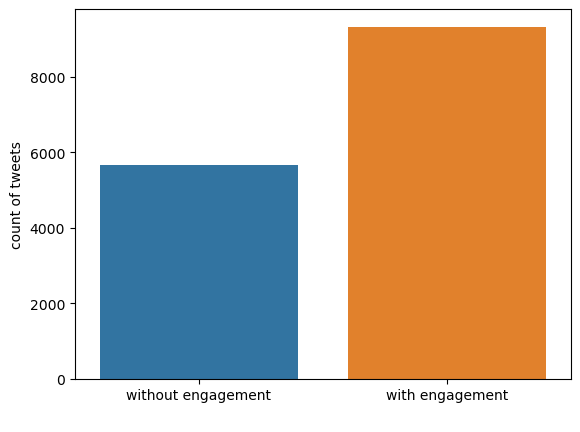

In [21]:
ax = sns.countplot(x=df_all['engage_binary'])
ax.set_xticklabels(['without engagement', 'with engagement'])
plt.xlabel(" ")
plt.ylabel("count of tweets")

In [98]:
def compound_hist(df, topic):
    plt.hist(df['compound'])
    plt.title(f"Distribution of Compound Scores of {topic}")
    plt.xlabel("Compound")
    plt.ylabel("Count")
    return plt

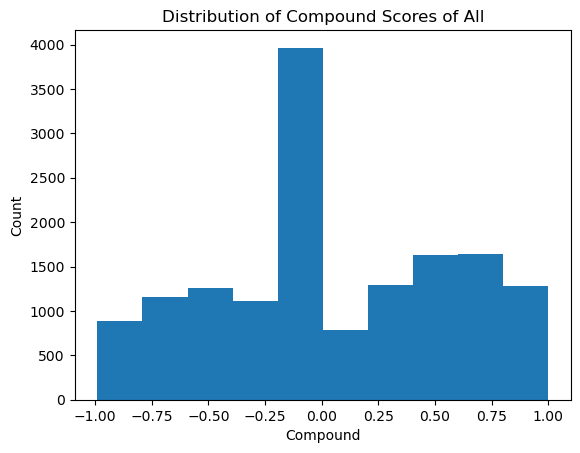

In [103]:
plt1 = compound_hist(df_all, 'All')

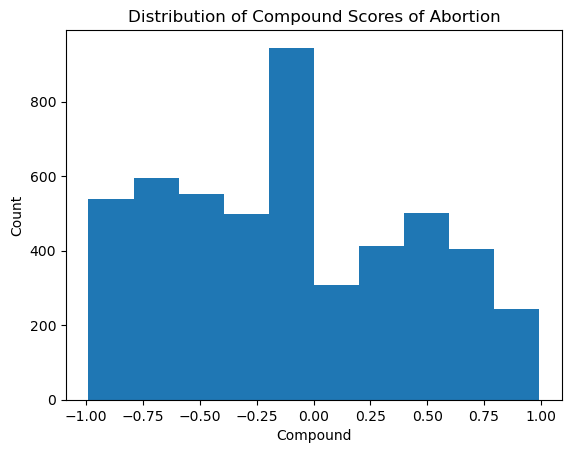

In [101]:
plt2 = compound_hist(df_abortion, 'Abortion')

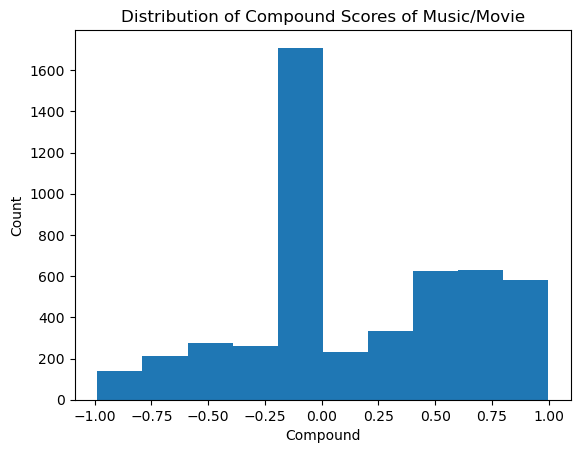

In [110]:
plt3 = compound_hist(df_music, 'Music/Movie')

Regression Models

In [66]:
# select non-zero engagemnet rows for linear regressions 
random_select = df_random[df_random['engagement'] > 0]
abortion_select = df_abortion[df_abortion['engagement'] > 0]
music_select = df_music[df_music['engagement'] > 0]

In [62]:
def linear_reg(df):
    scaler = StandardScaler()
    data = pd.DataFrame({'x': df['absolute intensity'], 
                         'confounder': df['followersCount'], 
                         'y': np.log(df['engagement'])})
    scaler.fit(data)
    df_scaled = pd.DataFrame(scaler.transform(data), columns=data.columns)

    model = smf.ols('y ~ x + confounder', data=df_scaled).fit()
    print(model.summary(), model.pvalues)

In [64]:
def logistic_reg(df):
    
    data = pd.DataFrame({'x': df['absolute intensity'], 
                         'confounder': df['followersCount'], 
                         'y': df['engage_binary']})

    formula = ('y ~ x + confounder')
    model = logit(formula=formula, data=data).fit()
    print(model.summary(), model.pvalues)

In [65]:
logistic_reg(df_random)

Optimization terminated successfully.
         Current function value: 0.643386
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Wed, 24 May 2023   Pseudo R-squ.:                0.003187
Time:                        15:14:45   Log-Likelihood:                -3216.9
converged:                       True   LL-Null:                       -3227.2
Covariance Type:            nonrobust   LLR p-value:                 3.419e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5246      0.050     10.565      0.000       0.427       0.622
x              0.2135      0

In [67]:
logistic_reg(df_abortion)

Optimization terminated successfully.
         Current function value: 0.662809
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Wed, 24 May 2023   Pseudo R-squ.:                 0.02688
Time:                        15:16:07   Log-Likelihood:                -3314.0
converged:                       True   LL-Null:                       -3405.6
Covariance Type:            nonrobust   LLR p-value:                 1.750e-40
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0047      0.053     -0.089      0.929      -0.109       0.099
x              0.4796      0

In [68]:
logistic_reg(df_music)

Optimization terminated successfully.
         Current function value: 0.649750
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 5000
Model:                          Logit   Df Residuals:                     4997
Method:                           MLE   Df Model:                            2
Date:                Wed, 24 May 2023   Pseudo R-squ.:                0.008883
Time:                        15:16:17   Log-Likelihood:                -3248.7
converged:                       True   LL-Null:                       -3277.9
Covariance Type:            nonrobust   LLR p-value:                 2.261e-13
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3114      0.045      6.993      0.000       0.224       0.399
x              0.6216      0.

In [63]:
linear_reg(random_select)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     23.02
Date:                Wed, 24 May 2023   Prob (F-statistic):           1.18e-10
Time:                        15:10:50   Log-Likelihood:                -4611.4
No. Observations:                3266   AIC:                             9229.
Df Residuals:                    3263   BIC:                             9247.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.231e-16      0.017  -7.08e-15      1.0

In [69]:
linear_reg(abortion_select)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     28.77
Date:                Wed, 24 May 2023   Prob (F-statistic):           4.24e-13
Time:                        15:16:27   Log-Likelihood:                -4068.0
No. Observations:                2887   AIC:                             8142.
Df Residuals:                    2884   BIC:                             8160.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   6.451e-17      0.018    3.5e-15      1.0

In [70]:
linear_reg(music_select)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     31.61
Date:                Wed, 24 May 2023   Prob (F-statistic):           2.55e-14
Time:                        15:16:38   Log-Likelihood:                -4482.3
No. Observations:                3181   AIC:                             8971.
Df Residuals:                    3178   BIC:                             8989.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.034e-16      0.018  -5.89e-15      1.0

Valence involved

In [71]:
df_abortion_neg = df_abortion[df_abortion['compound'] < -0.05]
df_abortion_pos = df_abortion[df_abortion['compound'] > 0.05]

df_music_neg = df_music[df_music['compound'] < -0.05]
df_music_pos = df_music[df_music['compound'] > 0.05]

df_random_neg = df_random[df_random['compound'] < -0.05]
df_random_pos = df_random[df_random['compound'] > 0.05]

In [90]:
for df in [df_abortion_neg, df_abortion_pos, df_music_neg, df_music_pos, df_random_neg, df_random_pos]:
    logistic_reg(df)

Optimization terminated successfully.
         Current function value: 0.663787
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 2363
Model:                          Logit   Df Residuals:                     2360
Method:                           MLE   Df Model:                            2
Date:                Wed, 24 May 2023   Pseudo R-squ.:                 0.02476
Time:                        15:34:29   Log-Likelihood:                -1568.5
converged:                       True   LL-Null:                       -1608.3
Covariance Type:            nonrobust   LLR p-value:                 5.103e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1175      0.109      1.082      0.279      -0.095       0.330
x              0.1782      0

In [91]:
df_abortion_select_neg = abortion_select[abortion_select['compound'] < -0.05]
df_abortio_select_pos = abortion_select[abortion_select['compound'] > 0.05]

df_music_select_neg = music_select[music_select['compound'] < -0.05]
df_music_select_pos = music_select[music_select['compound'] > 0.05]

df_random_select_neg = random_select[random_select['compound'] < -0.05]
df_random_select_pos = random_select[random_select['compound'] > 0.05]

In [92]:
for df in [df_abortion_select_neg, df_abortio_select_pos, df_music_select_neg, 
           df_music_select_pos, df_random_select_neg, df_random_select_pos]:
    linear_reg(df)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     30.18
Date:                Wed, 24 May 2023   Prob (F-statistic):           1.49e-13
Time:                        15:35:47   Log-Likelihood:                -1911.5
No. Observations:                1368   AIC:                             3829.
Df Residuals:                    1365   BIC:                             3845.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -6.939e-18      0.026  -2.62e-16      1.0

Visualization

In [104]:
def compound_engage_hist(num_bins, df, topic):
    bins_neg = np.linspace(-1, -0.05, (num_bins - 1)//2)
    bins_pos = np.linspace(0.05, 1, (num_bins - 1)//2)
    bins = np.concatenate((bins_neg, bins_pos))
    # bins = np.linspace(-1, 1, num_bins+1)
    random_list = []
    for i in range(len(bins) - 1):
        bin_data = df[(df['compound'] >= bins[i]) & (df['compound'] < bins[i + 1])]
        engage_counts = bin_data['engage_binary'].value_counts()
        for engage, count in engage_counts.items():
            random_list.append((engage, count, (bins[i], bins[i+1])))
    
    random_bins = pd.DataFrame(random_list, columns=['engage_binary', 'count', 'bins'])
    grouped_df = random_bins.groupby('bins').sum()
    count_sum = np.array(grouped_df['count'])
    engage_count = np.array(random_bins[random_bins['engage_binary']==1]['count'])
    engage_prop = engage_count / count_sum
    fig, ax = plt.subplots()
    n, bins, patches = ax.hist(bins[:-1], bins=bins, weights=engage_prop)
    colors = ['#1f77b4' if b < -0.05 else 'orange' if b >= 0.05 else 'grey' for b in bins]
    for i in range(len(patches)):
        patches[i].set_facecolor(colors[i])
    ax.axvline(x=-0.05, color='r', linestyle='--')
    ax.axvline(x=0.05, color='r', linestyle='--')
    ax.text(-0.75, 0.3, 'Negative', fontsize=12, color='black')
    ax.text(0.4, 0.3, 'Positive', fontsize=12, color='black')
    ax.set_ylim(0,1)
    ax.set_xlabel("compound")
    ax.set_ylabel("proportion of tweets with at least one engagement")
    ax.set_title(f"Proportion of Engaged Tweets over Compound for {topic} Topic")
    plt.show()

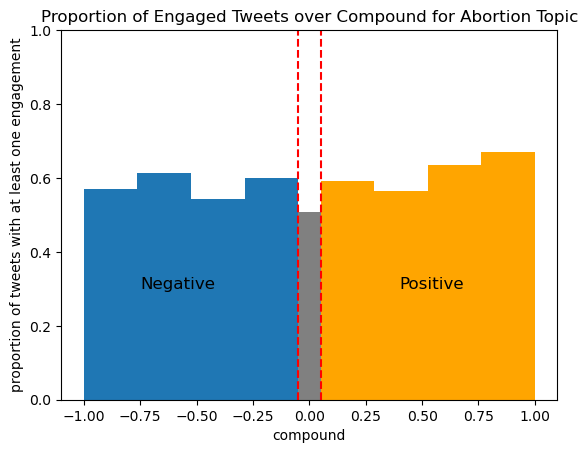

In [107]:
compound_engage_hist(11, df_abortion, 'Abortion')

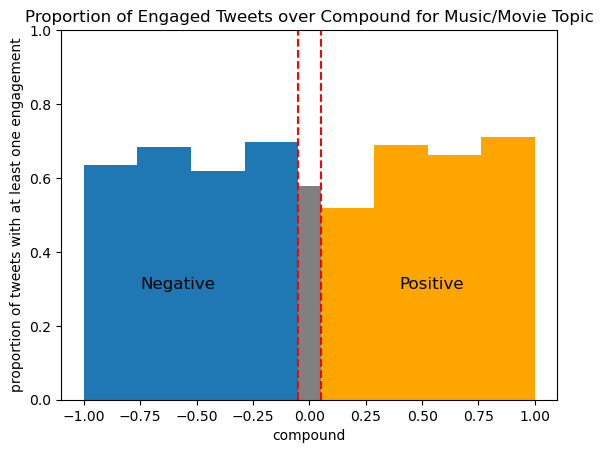

In [108]:
compound_engage_hist(11, df_music, 'Music/Movie')

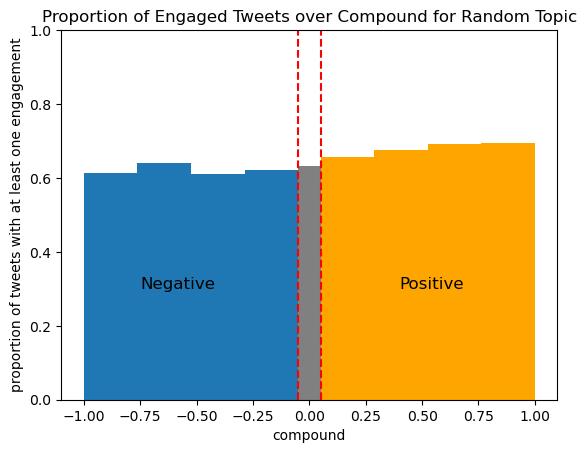

In [109]:
compound_engage_hist(11, df_random, 'Random')

In [111]:
def compound_hist_binary_engage(df, topic, num_bins):
    fig, ax = plt.subplots()

    ax.hist(df[df['engage_binary'] == 1]['compound'], alpha = 0.5, bins=num_bins)
    ax.hist(df[df['engage_binary'] == 0]['compound'], alpha = 0.5, bins=num_bins)

    ax.legend(df['engage_binary'], labels=['with engagement', 'no engagement'])
    ax.axvline(x=-0.05, color='r', linestyle='--')
    ax.axvline(x=0.05, color='r', linestyle='--')
    ax.text(-0.75, 300, 'Negative', fontsize=12, color='black')
    ax.text(0.4, 300, 'Positive', fontsize=12, color='black')
    
    ax.set_title(f"Distribution of Compound for {topic} Topic")
    ax.set_xlabel("compound")

    plt.show()

/var/folders/8q/bq8pw32x58s8y8_tnlr5dyvm0000gn/T/ipykernel_43335/3159375454.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(df['engage_binary'], labels=['with engagement', 'no engagement'])


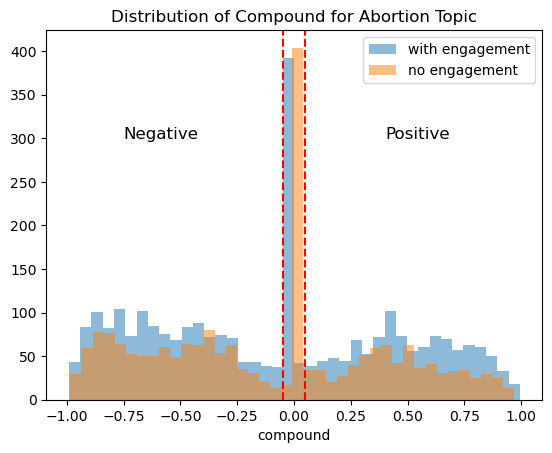

In [114]:
compound_hist_binary_engage(df_abortion, "Abortion", 40)

/var/folders/8q/bq8pw32x58s8y8_tnlr5dyvm0000gn/T/ipykernel_43335/3159375454.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(df['engage_binary'], labels=['with engagement', 'no engagement'])


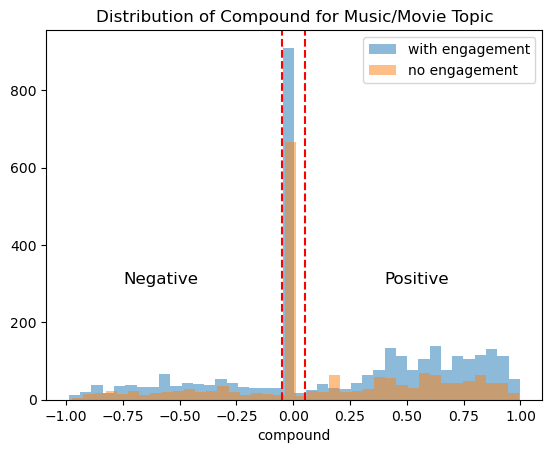

In [115]:
compound_hist_binary_engage(df_music, "Music/Movie", 40)

/var/folders/8q/bq8pw32x58s8y8_tnlr5dyvm0000gn/T/ipykernel_43335/3159375454.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  ax.legend(df['engage_binary'], labels=['with engagement', 'no engagement'])


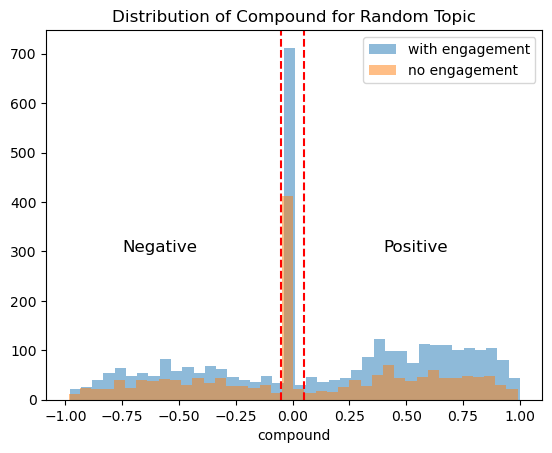

In [116]:
compound_hist_binary_engage(df_random, "Random", 40)

In [117]:
def compound_hist_all(df, topic, num_bins, fig_num):
    fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(24, 6))
    bins = np.linspace(-1, 1, num_bins+1)

    for i in range(5):
        sns.histplot(df[df['engagement_level'] == i]['compound'], bins=bins, 
                 kde=True, ax=axs[i])
        axs[i].lines[0].set_color('crimson')
        axs[i].set_xlabel('compound', fontname="Times New Roman")
        axs[i].set_title(f"Engagement Level {i + 1}", fontname="Times New Roman")
    fig.suptitle(f'Figure {fig_num}. Distribution of Compound With Engagement Level for {topic} Topic', 
                 fontsize=20,
                 fontname="Times New Roman")
 
    plt.show()

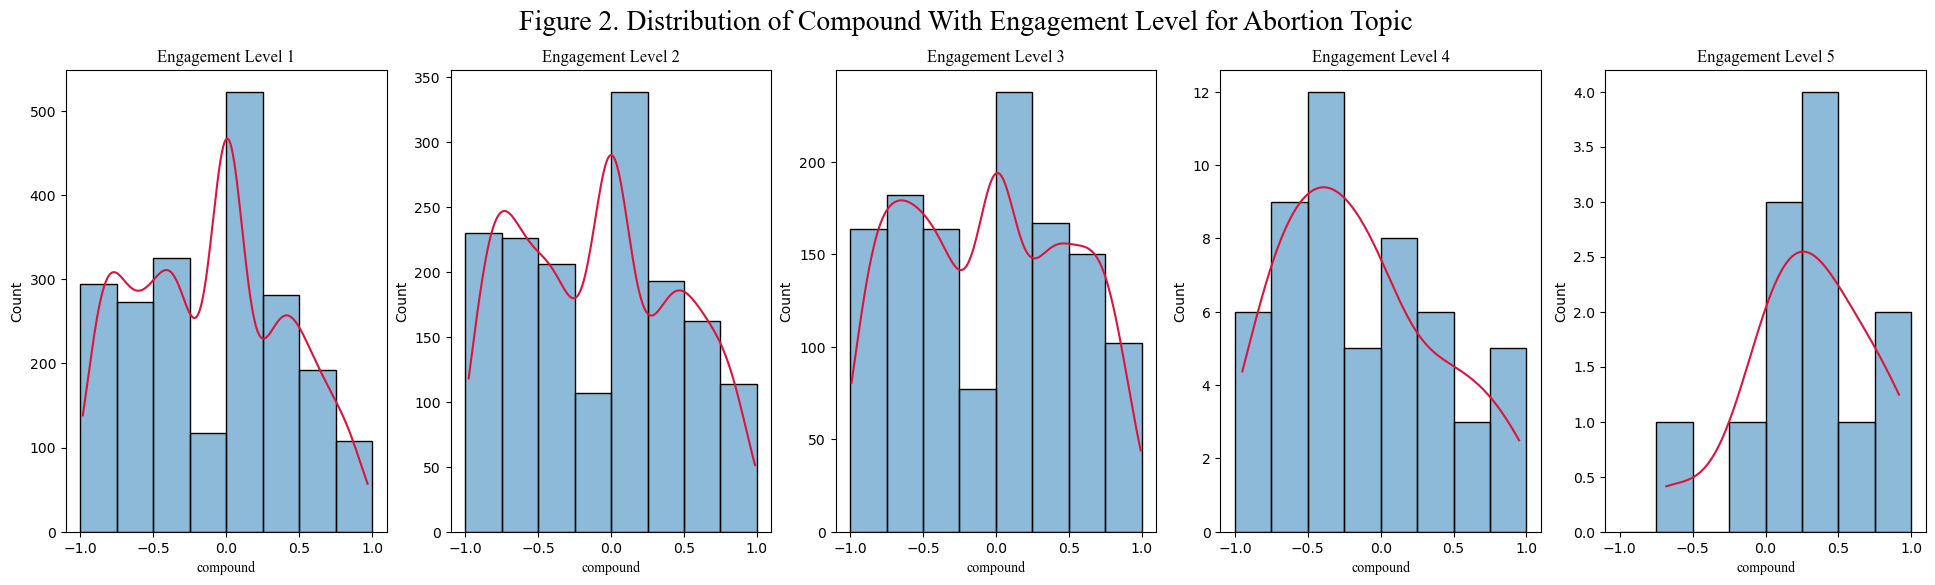

In [118]:
compound_hist_all(df_abortion, "Abortion", 8, 2)

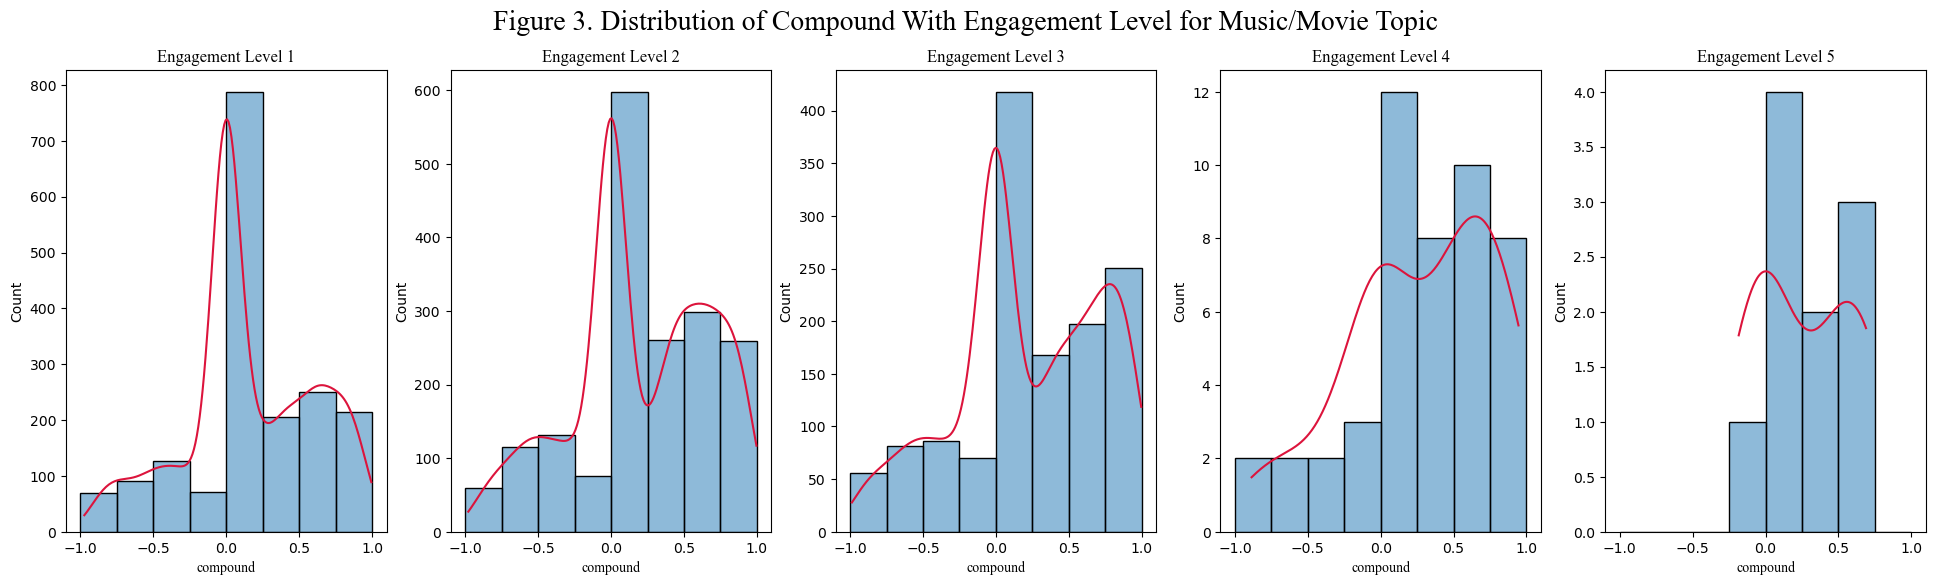

In [121]:
compound_hist_all(df_music, "Music/Movie", 8, 3)

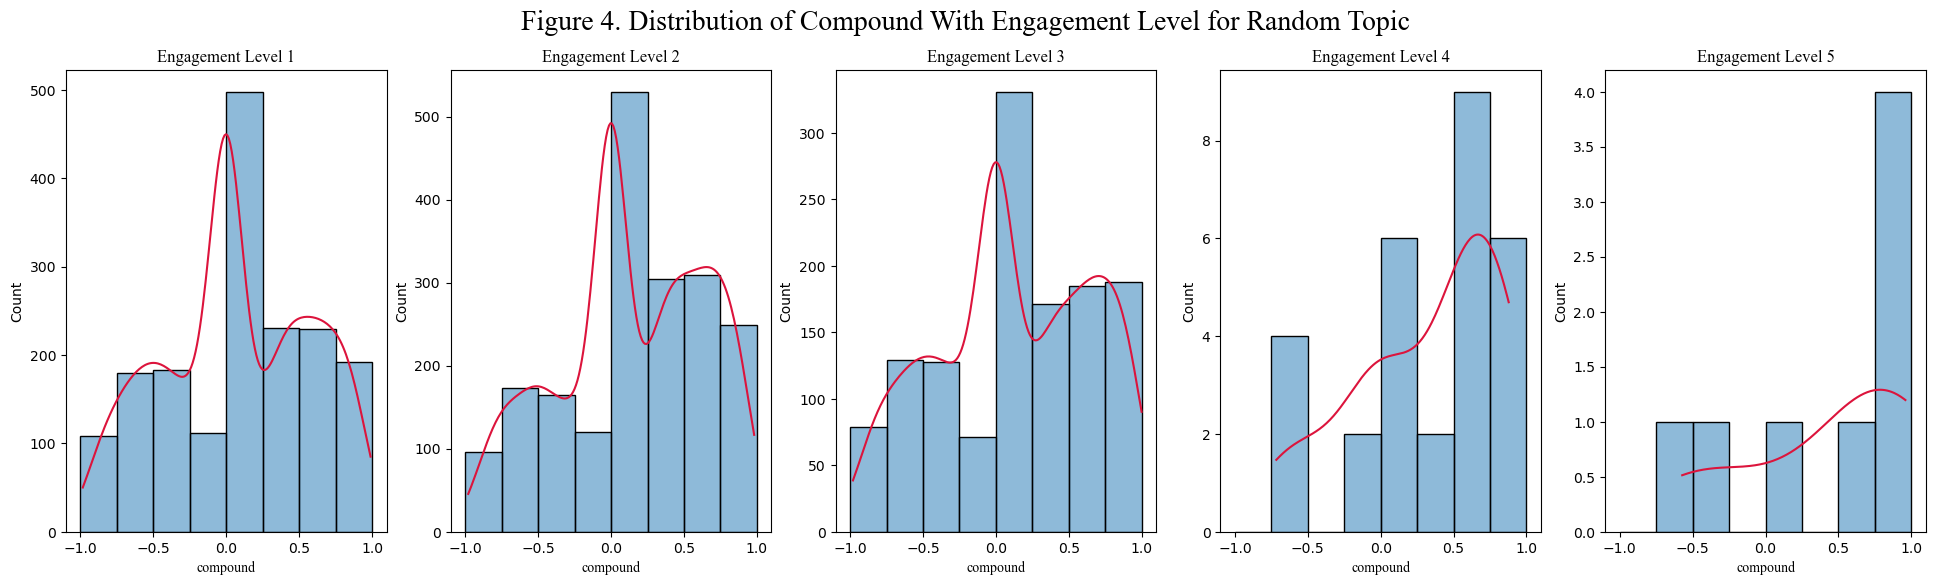

In [122]:
compound_hist_all(df_random, "Random", 8, 4)

More Exploration

In [123]:
abortion_pos_engage = (df_abortion_pos['engage_binary'] == 1).sum()
abortion_pos_unengage = (df_abortion_pos['engage_binary'] == 0).sum()
abortion_neg_engage = (df_abortion_neg['engage_binary'] == 1).sum()
abortion_neg_unengage = (df_abortion_neg['engage_binary'] == 0).sum()

In [124]:
music_pos_engage = (df_music_pos['engage_binary'] == 1).sum()
music_pos_unengage = (df_music_pos['engage_binary'] == 0).sum()
music_neg_engage = (df_music_neg['engage_binary'] == 1).sum()
music_neg_unengage = (df_music_neg['engage_binary'] == 0).sum()

In [126]:
from scipy.stats import fisher_exact
contingency_table = [[abortion_pos_engage, abortion_pos_unengage], [abortion_neg_engage, abortion_neg_unengage]]

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)

# Print the results
print("Odds ratio:", odds_ratio)
print("p-value:", p_value)

Odds ratio: 1.1289885718110249
p-value: 0.05981343734483231


In [127]:
contingency_table = [[music_pos_engage, music_pos_unengage], [music_neg_engage, music_neg_unengage]]

# Perform Fisher's exact test
odds_ratio, p_value = fisher_exact(contingency_table)

# Print the results
print("Odds ratio:", odds_ratio)
print("p-value:", p_value)

Odds ratio: 1.0335923893705874
p-value: 0.6920216589535111


In [130]:
df_abortion[df_abortion['engagement_level']==3]['Tweet'].iloc[1]

"2/ anencephaly and could never survive. Still, Casiano had to give birth because Texas abortion laws do not have an exception for fetal anomalies. After her experience, she says, she won't get pregnant again for fear of reliving the experience.\nhttps://t.co/3DpzkyGKqA"

Extreme Engagement: 
positive:
cheering, appealing, showing caring, asking for opinions 

High engagement:
negative:
medium negativity 
anecdote 
political 

In [131]:
df_abortion[df_abortion['engagement_level']==3]['Tweet'].iloc[5]

'40% of people in this country wants abortion to be illegal. That number goes to 60% amongst republicans. \n\nIf you think abortion is a losing issue for republicans, then it can only be due to your ignorance. It’s only a losing issue if you compromise.'